In [14]:
import cv2
import json
import math
import io
import os
import sys
import torch
import time

import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple
from PIL import Image, ImageDraw, ImageFont

from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.io import read_image
import torchvision.transforms as tvt
import torchvision.transforms.functional as tvf
from torch.utils.data.dataloader import default_collate
from torchvision.utils import make_grid, draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from engine import train_one_epoch, evaluate

from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn, \
fasterrcnn_resnet50_fpn, retinanet_resnet50_fpn, ssdlite320_mobilenet_v3_large, ssd300_vgg16
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [15]:
# from https://github.com/pytorch/pytorch/issues/1512#issuecomment-973112191
def target_collate(batch: List[Tuple[torch.Tensor, Any]]) -> Tuple[torch.Tensor, List[Any]]:
    """Custom collate function to handle variable number of bounding boxes per image

    Args:
        batch (List[Tuple[torch.Tensor, Any]]): Output from ``dataset.__getitem__``

    Returns:
        Tuple[torch.Tensor, List[Any]]: Singular image batch tensor
            plus a list of variable-number bounding box tensors
    """
    imgs, targets = zip(*batch)
    return torch.stack(imgs), list(targets)

class PhantomDataset(Dataset):
    def __init__(self, json_file: str, image_root: str, transform: tvt.Compose = None) -> None:
        """Dataset class for Phantom Dataset.

        Args:
            json_file (str): Path to the JSON file containing dataset information.
            image_root (str): Root directory containing images.
            transform (tvt.Compose, optional): Composed torchvision transform to apply to the data. Defaults to None.
        """
        with open(json_file) as f:
            self.data = json.load(f)

        self.id = list(self.data['projects'].keys())[0]
        self.image_root = image_root
        self.annotated_frames = [int(x) for x in list(self.data['projects'][self.id]['labels'][0]['annotations']['frames'].keys())]
        self.transform = transform
        self.data_file = json_file

    def __len__(self) -> int:
        return len(self.annotated_frames) - 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, Any]]:
        str_idx = str(self.annotated_frames[idx])
        image_idx = str(int(str_idx) - 1)
        all_boxes = []
        all_areas = []

        sample = self.data['projects'][self.id]['labels'][0]['annotations']['frames']

        for feature_key in list(sample[str_idx]['objects'].keys()):
            feature = sample[str_idx]['objects'][feature_key]

            if feature['annotation_kind'] == 'VideoBoundingBox':
                top = int(feature['bounding_box']['top'])
                left = int(feature['bounding_box']['left'])
                height = int(feature['bounding_box']['height'])
                width = int(feature['bounding_box']['width'])
                box = [left, top, left+width, top+height]
                all_boxes.append(box)
                area = (box[3] - box[1]) * (box[2] - box[0])
                all_areas.append(area)

            elif feature['annotation_kind'] == 'VideoPolyline':
                all_x = [d['x'] for d in feature['line']]
                all_y = [d['y'] for d in feature['line']]
                box = [min(all_x), min(all_y), max(all_x), max(all_y)]
                all_boxes.append(box)
                area = (box[3] - box[1]) * (box[2] - box[0])
                all_areas.append(area)

        image_path = self.image_root + image_idx + ".jpg"
        image = read_image(image_path)

        bbox = tv_tensors.BoundingBoxes(all_boxes,
                                       format="XYXY",
                                       canvas_size=image.shape[-2:])
        num_objs = len(all_boxes)

        target = {}
        target['boxes'] = bbox
        target['labels'] = torch.ones((num_objs,), dtype=torch.int64)
        target["image_id"] = int(str_idx)
        target["area"] = torch.Tensor(all_areas)
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        if self.transform:
            out_img, out_target = self.transform(image, target)
        else:
            out_img = image
            out_target = target

        return out_img, out_target

In [16]:
transforms = v2.Compose([
    v2.RandomApply([v2.RandomIoUCrop()], p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize(size=(512, 512)),
    v2.SanitizeBoundingBoxes(labels_getter=None),
    v2.ToDtype(torch.float, scale=True),
    v2.ToPureTensor()
])

valid_transforms = v2.Compose([
    v2.SanitizeBoundingBoxes(labels_getter=None),
    v2.ToDtype(torch.float, scale=True),
    v2.ToPureTensor()])

df_vid_0 = PhantomDataset('/content/drive/MyDrive/Phantom Videos/0.ndjson',
                          '/content/drive/MyDrive/Phantom Videos/0/',
                          transform=transforms)

df_vid_1 = PhantomDataset('/content/drive/MyDrive/Phantom Videos/1.ndjson',
                          '/content/drive/MyDrive/Phantom Videos/1/',
                          transform=transforms)

df_vid_3 = PhantomDataset('/content/drive/MyDrive/Phantom Videos/3.ndjson',
                          '/content/drive/MyDrive/Phantom Videos/3/',
                          transform=valid_transforms)

df_vid_4 = PhantomDataset('/content/drive/MyDrive/Phantom Videos/4.ndjson',
                          '/content/drive/MyDrive/Phantom Videos/4/',
                          transform=valid_transforms)

df_vid_5 = PhantomDataset('/content/drive/MyDrive/Phantom Videos/5.ndjson',
                          '/content/drive/MyDrive/Phantom Videos/5/',
                          transform=transforms)

df_vid_6 = PhantomDataset('/content/drive/MyDrive/Phantom Videos/6.ndjson',
                          '/content/drive/MyDrive/Phantom Videos/6/',
                          transform=transforms)


train_dataset = ConcatDataset([df_vid_0, df_vid_1, df_vid_5, df_vid_6])
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=8, collate_fn=target_collate)
valid_loader = DataLoader(dataset=df_vid_3, batch_size=8, collate_fn=target_collate)
test_loader = DataLoader(dataset=df_vid_4, batch_size=1, collate_fn=target_collate, shuffle=True)

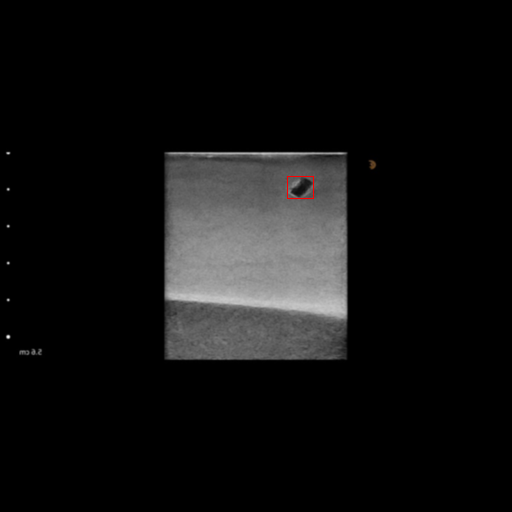

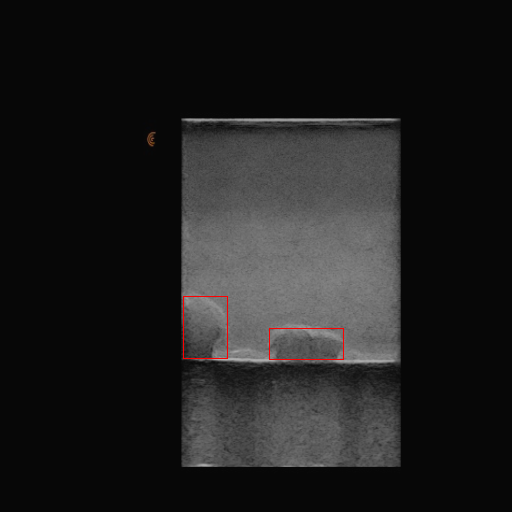

In [17]:
# display a couple augmented images from the training set
for i, (img, target) in enumerate(train_loader):
  img_1 = img[0]
  target_1 = target[0]
  pil_image = Image.fromarray(np.transpose(np.squeeze(img_1.numpy() * 255.0).astype(np.uint8), (1, 2, 0)), mode='RGB')
  draw = ImageDraw.Draw(pil_image)
  if i < 2:
    for b in target_1['boxes']:
      draw.rectangle(b.tolist(), outline="red")
    display(pil_image)
  else: break

In [18]:
def get_pretrained_model(model_name: str):
    """Return a pre-trained object detection model based on the provided model name.

    Args:
        model_name (str): Name of the pre-trained object detection model.

    Returns:
        torch.nn.Module: Pre-trained object detection model.
    """
    num_classes = 2  # lesion and background

    if model_name == 'ssdlite320_mobilenet_v3_large':
        return ssdlite320_mobilenet_v3_large(weights_backbone='DEFAULT', num_classes=num_classes)
    elif model_name == 'ssd300_vgg16':
        return ssd300_vgg16(weights_backbone='DEFAULT', num_classes=num_classes, trainable_backbone_layers=5)
    elif model_name == 'retinanet_resnet50_fpn':
        model = retinanet_resnet50_fpn(weights='COCO_V1')
        in_features = model.head.classification_head.conv[0][0].in_channels
        num_anchors = model.head.classification_head.num_anchors
        model.head.classification_head.num_classes = num_classes
        cls_logits = torch.nn.Conv2d(256, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
        torch.nn.init.normal_(cls_logits.weight, std=0.01)
        torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
        model.head.classification_head.cls_logits = cls_logits
        return model
    elif model_name == 'fasterrcnn_mobilenet_v3_large_320_fpn':
        model = fasterrcnn_mobilenet_v3_large_320_fpn(weights='COCO_V1')
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model
    elif model_name == 'fasterrcnn_resnet50_fpn':
        model = fasterrcnn_resnet50_fpn()
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

In [20]:
# get model
model = get_pretrained_model('ssdlite320_mobilenet_v3_large')

# training logic from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.001, # 0.005 for every architecture except ssd300_vgg16
    momentum=0.5, # 0.9 for every architecture except ssd300_vgg16
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 43.6MB/s]


## Model training

In [21]:
# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_loader, device=device)

print("That's it!")

Epoch: [0]  [ 0/96]  eta: 0:13:47  lr: 0.000012  loss: 12.7387 (12.7387)  bbox_regression: 5.4532 (5.4532)  classification: 7.2855 (7.2855)  time: 8.6213  data: 4.2166
Epoch: [0]  [10/96]  eta: 0:10:44  lr: 0.000117  loss: 13.4472 (14.8573)  bbox_regression: 6.1173 (7.4554)  classification: 7.4663 (7.4020)  time: 7.4936  data: 4.0895
Epoch: [0]  [20/96]  eta: 0:09:38  lr: 0.000222  loss: 14.8048 (16.4115)  bbox_regression: 7.4997 (8.9994)  classification: 7.4663 (7.4121)  time: 7.5642  data: 4.1851
Epoch: [0]  [30/96]  eta: 0:08:23  lr: 0.000327  loss: 15.4096 (15.9787)  bbox_regression: 8.6663 (8.8706)  classification: 6.8200 (7.1081)  time: 7.7116  data: 4.3147
Epoch: [0]  [40/96]  eta: 0:07:06  lr: 0.000432  loss: 12.9462 (15.3055)  bbox_regression: 7.2551 (8.5579)  classification: 6.0200 (6.7475)  time: 7.6172  data: 4.4036
Epoch: [0]  [50/96]  eta: 0:05:48  lr: 0.000537  loss: 12.0617 (14.8017)  bbox_regression: 6.7249 (8.3195)  classification: 5.3367 (6.4822)  time: 7.4627  data:

## Model evaluation

In [22]:
evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [  0/256]  eta: 0:00:25  model_time: 0.0807 (0.0807)  evaluator_time: 0.0058 (0.0058)  time: 0.0994  data: 0.0128
Test:  [100/256]  eta: 0:00:14  model_time: 0.0758 (0.0739)  evaluator_time: 0.0058 (0.0062)  time: 0.1035  data: 0.0167
Test:  [200/256]  eta: 0:00:05  model_time: 0.0781 (0.0790)  evaluator_time: 0.0060 (0.0067)  time: 0.1004  data: 0.0151
Test:  [255/256]  eta: 0:00:00  model_time: 0.1059 (0.0823)  evaluator_time: 0.0106 (0.0071)  time: 0.1344  data: 0.0173
Test: Total time: 0:00:26 (0.1052 s / it)
Averaged stats: model_time: 0.1059 (0.0823)  evaluator_time: 0.0106 (0.0071)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small 

### Example model loading in
Replace weights path with the path to the pretrained weights you can download for the phantom dataset.

In [25]:
model2 = ssd300_vgg16(num_classes=2)
model2.load_state_dict(torch.load('ssd300_vgg16.pth', map_location=torch.device('cpu')))
model2.eval()

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:07<00:00, 72.3MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

### Prediction visualization

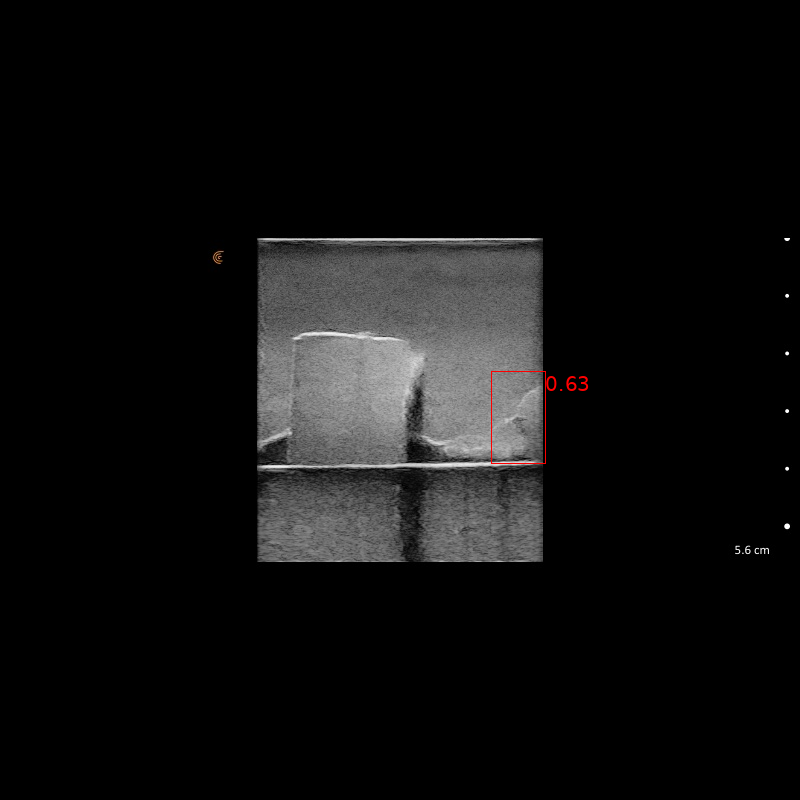

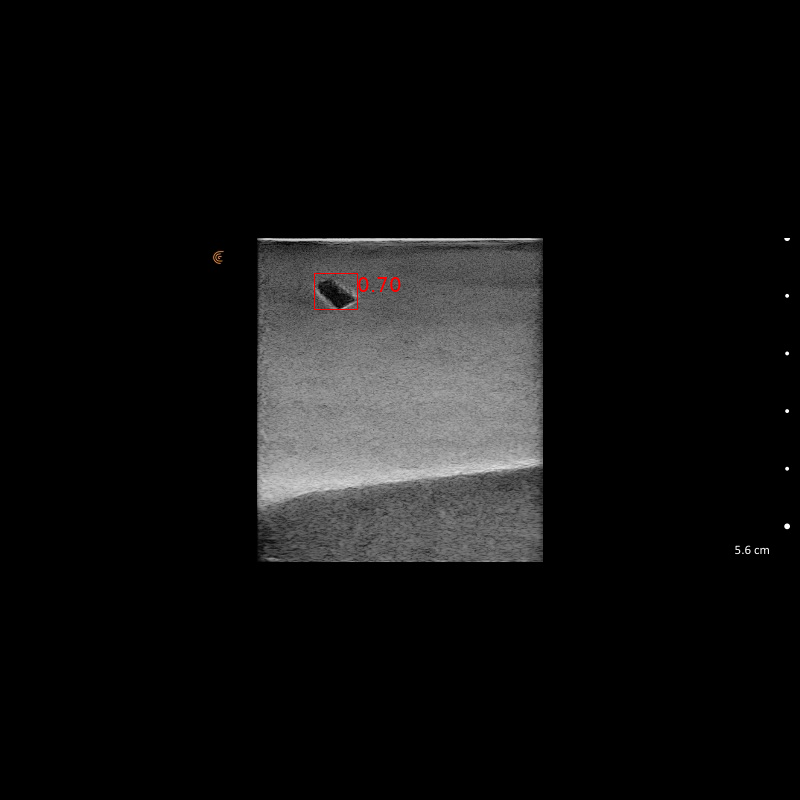

In [26]:
font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
font = ImageFont.truetype(font_path, size=20)

for i, (img, target) in enumerate(test_loader):
  if i < 2:
    pred = model2(img)
    pil_image = Image.fromarray(np.transpose(np.squeeze(img[0].numpy() * 255.0).astype(np.uint8), (1, 2, 0)), mode='RGB')
    draw = ImageDraw.Draw(pil_image)
    for j, b in enumerate(pred[0]['boxes']):
      if j < 1:
        draw.rectangle(b.tolist(), outline="red")
        score = pred[0]['scores'][0]
        draw.text((b[2], b[1]), f'{score:.2f}', fill ="red", font=font)
    display(pil_image)
  else: break